In [2]:
import xarray as xr
import xrspatial
import rioxarray
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import GroupKFold, GridSearchCV
import os
import lightgbm as lgb
import fasttreeshap
import warnings
import geopandas as gpd

try:
    import util
except ImportError:
    if 'notebooks' in os.getcwd():
        os.chdir("..")
finally:
    import util

ImportError on util.training: No module named 'torch'. Module util.training will not be loaded.


Prepare data. Here we are trying to replicate the RF described in [Preisler et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0378112717304772) so we need to do some feature engineering to match their work.

In [3]:
ds = xr.load_dataset("mort_datasets/westmort.nc").rio.write_crs(3857)
ds = ds.where(ds["treecover"] >= 10)
ds

<xarray.Dataset> Size: 248MB
Dimensions:      (y: 652, x: 590, time: 25)
Coordinates:
  * x            (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y            (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time         (time) int64 200B 1999 2000 2001 2002 ... 2020 2021 2022 2023
    spatial_ref  int64 8B 0
Data variables: (12/16)
    elev         (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    slope        (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    northness    (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    eastness     (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    fire         (time, y, x) float32 38MB nan nan nan nan ... nan nan nan nan
    prcp         (time, y, x) float32 38MB nan nan nan nan ... nan nan nan nan
    ...           ...
    abies        (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    pinus        (y, x) float64 3MB nan nan nan nan nan ... nan nan nan nan nan
    populus      (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    pseudotsuga  (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    tsuga        (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    gfw_damage   (time, y, x) float32 38MB nan nan nan nan ... nan nan nan nan

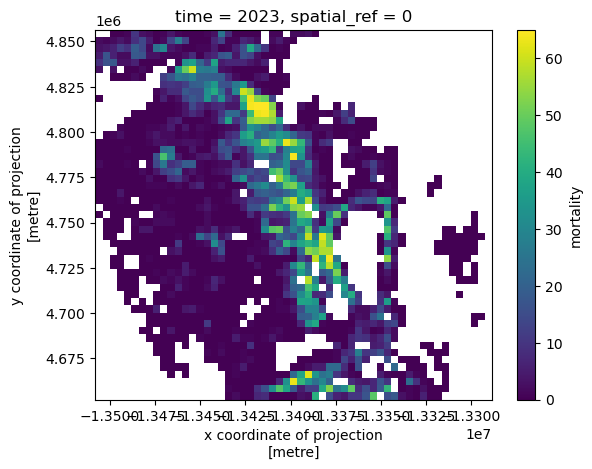

In [4]:
def get_fig5_inset_regions():
    regions = gpd.read_file("data_in/figure_overlays.shp")
    regions["centroid_y"] = regions.geometry.centroid.y
    regions = regions.sort_values("centroid_y", ascending=False, ignore_index=True)
    regions["label"] = ["(a)", "(b)", "(c)"]

    return regions

regions = get_fig5_inset_regions()

ds.mortality.sel(time=2023).rio.clip_box(*regions.geometry[1].bounds).plot()

In [5]:
kernel = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
])

def focal_max(arr):
    arr = arr.isel(time=0)
    return xrspatial.focal.focal_stats(arr, kernel, stats_funcs=["max"]).isel(stats=0, drop=True)

def make_autocor_covariates(ds, target):
    rhost1 = (ds["treecover"] - ds[target]).clip(0, 100).shift(time=1).rename("rhost1")
    # xrspatial only convolves on 2D arrays so we have to do this
    # groupby trick.
    near1  = ds[target].groupby("time").apply(focal_max).shift(time=1).rename("near1")
    mort1  = ds[target].shift(time=1).rename("mort1")
    return rhost1, near1, mort1

# Make these for both ADS and GFW so we can fit all the models in one shot
ds["rhost1"], ds["near1"], ds["mort1"] = make_autocor_covariates(ds, "mortality")
ds["gfw_rhost1"], ds["gfw_near1"], ds["gfw_mort1"] = make_autocor_covariates(ds, "gfw_damage")

36-year average precipitation. They based this off of the PRISM dataset but I think we can take a long-term average and just call it good.

In [6]:
ds["prcp_avg"] = ds.prcp.mean(dim="time")

fire: "Area affected by fire 2–4 yr prior"

In [7]:
ds["fire_roll_sum"] = ds.fire.rolling(time=3).sum()

There's a lot of shifting variables here to create the lagged covariates described in the paper. By convention *we will not modify coordinates of the prediction target*. Only the covariates get shifted. Note that shifts are positive because we are moving data from the past to match the position of the mortality label.

In [8]:
ds["prcp1"]  = ds["prcp"].shift(time=1)
ds["prcp2"]  = ds["prcp"].shift(time=2)
ds["prcp3"]  = ds["prcp"].shift(time=3)
ds["prcp4"]  = ds["prcp"].shift(time=4)
ds["tmin1"]  = ds["tmin"].shift(time=1)
ds["vp1"]    = ds["vp"].shift(time=1)
ds["fire24"] = ds["fire_roll_sum"].shift(time=2)

Now we split the dataset into training and validation. The below functions make it possible to mimic the windowing we did in the Unet experiment. Since the Unet didn't work very well we can just use all the data we have available.

In [9]:
def patch_filter(ds, batch, prop_valid=0.70):
    # Accept patch if the last time step doesn't have too many NaNs.
    nan_mask = ds.isel(**batch).isel(time=-1).isnull().astype(np.float32)
    
    return 1 - nan_mask.mean() >= prop_valid

def pointwise_select_with_mask(da, mask):
    '''
    Select elements from ``da`` on a new dimension, defined by positive
    values in ``mask``.
    '''
    indices = np.argwhere(mask.data)
    selectors = {
        dim:xr.DataArray(indices[:, i], dims="sample")
        for i, dim in enumerate(mask.dims)
    }
    return da.isel(**selectors)

def get_batchgen_mask(ds, target, input_dims, input_overlap, filter_fn=None):
    '''
    Return binary array indicating cells selected by a batch generator.
    '''
    bgen = xbatcher.BatchGenerator(
        ds[target],
        input_dims=input_dims,
        input_overlap=input_overlap,
        filter_fn=filter_fn
    )

    mask = xr.full_like(ds[target], 0)

    for _, slices in bgen._batch_selectors.selectors.items():
        slices = tuple(slices[0][d] for d in ds[target].dims)
        mask.values[slices] = 1

    return mask

# When training the unet, overlap results in pseudoreplication. Here
# the mask just flips that cell to positive twice so it doesn't matter.
# unet_dims = dict(x=64, y=64, time=5)
# unet_overlap = dict(x=24, y=24, time=4)

# mask_ads = get_batchgen_mask(ds, "mortality", unet_dims, unet_overlap, filter_fn=patch_filter)
# mask_gfw = get_batchgen_mask(ds, "gfw_damage", unet_dims, unet_overlap, filter_fn=patch_filter)

In [10]:
def dataset_to_dataframe(ds, target, vars_to_keep, mask=None):
    assert target == vars_to_keep[0]
    ds = ds[vars_to_keep]
    if mask is None:
        mask = ~(ds[target].isnull())
    df = pointwise_select_with_mask(ds, mask).to_dataframe()
    # Drop NaNs for target, then impute median for the rest
    df = df.apply(impute_median, axis=0)
    return df

def impute_median(x):
    return x.fillna(x.median())

weather_vars = ["fire24", "tmin1", "vp1", "prcp1", "prcp2", "prcp3", "prcp4", "prcp_avg"]
ba_vars = ["abies", "pinus", "populus", "tsuga", "pseudotsuga"]
topo_vars = ["elev", "slope", "northness", "eastness"]
ads_autocor = ["near1", "rhost1", "mort1"]
ads_target = "mortality"
gfw_autocor = ["gfw_near1", "gfw_rhost1", "gfw_mort1"]
gfw_target = "gfw_damage"

df_ads = dataset_to_dataframe(ds, "mortality" , [ads_target]+ads_autocor+weather_vars+ba_vars+topo_vars)
df_ads = df_ads.set_index(["time", "y", "x"])
df_gfw = dataset_to_dataframe(ds, "gfw_damage", [gfw_target]+gfw_autocor+weather_vars+ba_vars+topo_vars)
df_gfw = df_gfw.set_index(["time", "y", "x"])

In [11]:
print(df_ads.shape)
print(df_gfw.shape)

(1440085, 22)
(1842125, 22)


### ADS Model Training

Model training. As the above shapes indicate, there's a looooooot of data here. Initial tests showed that we don't need to use all of it to get a reasonable fit. An easier approach is to run temporal cross-validation on subsets of the training set. Exploratory analysis with hyperparameter tuning found that the variance in model performance across CV folds was larger than variance in model performance across hyperparameter combinations. In other words, messing with the LightGBM hyperparameters doesn't seem to have much of an effect on performance. So, we will keep the default parameters here.

In [12]:
# Helper functions
from tqdm.autonotebook import tqdm

def get_results(y, y_hat):
    mse = mean_squared_error(y, y_hat)
    nrmse = np.sqrt(mse) / np.std(y)
    r2 = r2_score(y, y_hat)
    ev = explained_variance_score(y, y_hat)
    return {
        "mse": mse,
        "nrmse": nrmse,
        "r2": r2,
        "exp_var": ev
    }

def split_xy(df, features, target):
    return (
        df[features].to_numpy(),
        df[target].to_numpy()
    )

In [13]:
def make_estimator():
    return lgb.LGBMRegressor(min_data_in_leaf=1000, verbosity=-1) # mitigate overfitting

def temporal_cross_validation(df, features_with_ac, features_no_ac, target, ac_target, times, time_window=4):
    '''
    Perform a temporal cross-validation run.
    '''
    for f in features_with_ac+features_no_ac+[target]:
        if f not in df.columns:
            raise ValueError(f"Feature {f} not present in input data frame.") 

    # Init results
    rf_results      = [] # full Rf
    rf_noac_results = [] # RF without AC vars
    lastobs_results = [] # just using the "mort1" column in the validation set
    spatavg_results = [] # just taking the per-pixel mean in the training set
    mean_results    = [] # just taking the mean of the validation set
    
    for valid_year in (rng := tqdm(times)):
        rng.set_description(f"Starting {valid_year}...") 
    
        rng.set_description("Subsetting dataframes...")
        train_years = [x for x in range(valid_year-4, valid_year)]
        train_df = df.loc[valid_year-4:valid_year-1]
        valid_df = df.loc[valid_year]
    
        X_train, y_train = split_xy(train_df, features_with_ac, target)
        X_valid, y_valid = split_xy(valid_df, features_with_ac, target)
        X_train_noac, _  = split_xy(train_df, features_no_ac, target)
        X_valid_noac, _  = split_xy(valid_df, features_no_ac, target)
    
        
        rng.set_description("Training full RF...")
        full_rf = make_estimator()
        full_rf.fit(X_train, y_train)
    
        rng.set_description("Evaluating full RF...")
        y_hat = full_rf.predict(X_valid)
        rf_result = get_results(y_valid, y_hat)
        rf_result["year"] = valid_year
    
        rng.set_description("Training no-AC RF...")
        noac_rf = make_estimator()
        noac_rf.fit(X_train_noac, y_train)
    
        rng.set_description("Evaluating no-AC RF...")
        y_hat = noac_rf.predict(X_valid_noac)
        rf_noac_result = get_results(y_valid, y_hat)
        rf_noac_result["year"] = valid_year
    
        rng.set_description("Evaluating last-obs model...")
        lastobs_result = get_results(y_valid, valid_df[ac_target])
        lastobs_result["year"] = valid_year
        
        rng.set_description("Evaluating spatial average model...")
        spatavg = train_df.groupby(level=["y", "x"]).mean()[target].rename("mort_spatavg")
        # Join this back on to the validation set. Inner join since some coords may not be present
        # in the training set.
        valid_df_join = valid_df.join(spatavg, on=["y", "x"], how="inner")
        spatavg_result = get_results(valid_df_join[target], valid_df_join["mort_spatavg"])
        spatavg_result["year"] = valid_year
    
        rng.set_description("Eavluating mean model...")
        mean_result = get_results(y_valid, np.zeros(y_valid.shape)+y_valid.mean())
        
        # Save results
        rf_results.append(rf_result)
        rf_noac_results.append(rf_noac_result)
        lastobs_results.append(lastobs_result)
        spatavg_results.append(spatavg_result)
        mean_results.append(mean_result)

    # Combine everything into a dataframe
    rf = pd.DataFrame(rf_results)
    rf["model"] = "full RF"
    rf_noac = pd.DataFrame(rf_noac_results)
    rf_noac["model"] = "noac RF"
    lastobs = pd.DataFrame(lastobs_results)
    lastobs["model"] = "lastobs"
    spatavg = pd.DataFrame(spatavg_results)
    spatavg["model"] = "spatavg"
    all_models = pd.concat([rf, rf_noac, lastobs, spatavg])

    return all_models

In [14]:
df_ads.index.get_level_values("time").unique()

Index([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023],
      dtype='int64', name='time')

In [15]:
# Trim the first couple of years because of missing records in the late 90s
times = list(range(2005, df_ads.index.get_level_values("time").max()+1))

warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

ads_result = temporal_cross_validation(
    df_ads,
    features_with_ac=ads_autocor+weather_vars+ba_vars+topo_vars,
    features_no_ac=weather_vars+ba_vars+topo_vars,
    target=ads_target,
    ac_target="mort1",
    times=times
)

  0%|          | 0/19 [00:00<?, ?it/s]

In [16]:
times = list(range(2005, df_gfw.index.get_level_values("time").max()+1))

gfw_result = temporal_cross_validation(
    df_gfw,
    features_with_ac=gfw_autocor+weather_vars+ba_vars+topo_vars,
    features_no_ac=weather_vars+ba_vars+topo_vars,
    target=gfw_target,
    ac_target="gfw_mort1",
    times=times
)

  0%|          | 0/19 [00:00<?, ?it/s]

divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
invalid value encountered in scalar divide


In [17]:
ads_result["data"] = "ADS"
gfw_result["data"] = "GFW"

all_result = pd.concat([ads_result, gfw_result])
all_result.to_csv("data_out/westmort_rf_result.csv")

Final model on everything except 2023 (for figures)

In [18]:
features_with_ac=ads_autocor+weather_vars+ba_vars+topo_vars
features_no_ac=weather_vars+ba_vars+topo_vars

in23 = df_ads.index.get_level_values("time") == 2023
X, y = split_xy(df_ads, features_with_ac, ads_target)
X_noac, _ = split_xy(df_ads, features_no_ac, ads_target)

X_train, y_train = X[~in23], y[~in23]
X_train_noac = X_noac[~in23]
X_valid, y_valid = X[ in23], y[ in23]
X_valid_noac = X_noac[ in23]

print("Fitting RF with AC features")
final_rf = make_estimator()
final_rf.fit(X_train, y_train)

Fitting RF with AC features


LGBMRegressor(min_data_in_leaf=1000, verbosity=-1)

In [19]:
y_valid_hat = final_rf.predict(X_valid)

print("Fitting RF without AC features")
final_rf_noac = make_estimator()
final_rf_noac.fit(X_train_noac, y_train)
y_valid_noac_hat = final_rf_noac.predict(X_valid_noac)

valid_df = df_ads[in23].copy()
valid_df["rf_predict"] = y_valid_hat
valid_df["rf_predict_noac"] = y_valid_noac_hat

Fitting RF without AC features


In [20]:
# Save everything out
final_rf.booster_.save_model("data_out/west_rf_ads.model")
final_rf.booster_.save_model("data_out/west_rf_noac_ads.model")

valid_df.to_csv("data_out/west_ads_2023.csv")

### SHAP

In [21]:
%%time
explainer = fasttreeshap.TreeExplainer(final_rf, algorithm="auto")
values = explainer(X).values
print(values.shape)

(1440085, 20)
CPU times: user 8min 40s, sys: 4.06 s, total: 8min 44s
Wall time: 3min 6s


In [22]:
# Convert the numpy array to dataframe and attach coordinates
# so we can get back to an xarray object.
values_df = pd.DataFrame(
    values,
    columns=features_with_ac,
    index=df_ads.index
)
values_df["mortality"] = df_ads["mortality"]
values_df["gbm_predict"] = final_rf.predict(X)
values_df["gbm_noac_predict"] = final_rf_noac.predict(X_noac)

In [23]:
values_xr23 = values_df.to_xarray().sel(time=2023).to_dataarray().rio.write_crs(3857)

In [24]:
values_xr23.to_netcdf("data_out/west_ads_2023_shap.nc")